https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

*LSTM* (*Long short-term memory*) es un tipo de red neuronal recurrente (RNN) que tiene una componente extra de memoria a largo plazo. La idea es que en muchas aplicaciones típicas de RNN, como series de tiempo o NLP, el efecto de los primeros inputs a la red eventualmente desaparece. En series de tiempo esto puede hacer que la red no logre capturar patrones a largo plazo, en NLP que las últimas palabras de un texto tengan mucho más peso que las primeras. Las redes *LSTM* buscan dar una solución a esto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set( rc={'figure.figsize': (15, 8)})

In [3]:
stations_maxima = pd.read_excel('data/Estaciones.xlsx', sheet_name='Maximos', header=1, parse_dates=['Año hid'])

In [4]:
dataset = stations_maxima['San Luis Tucuman'].dropna().values

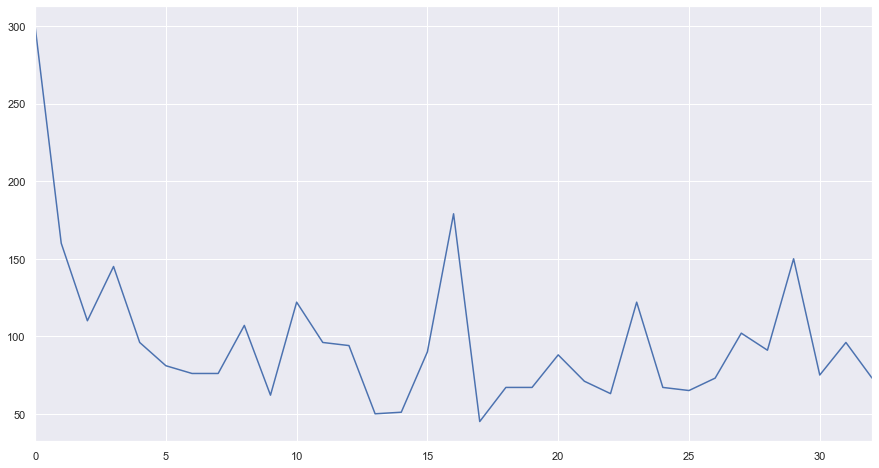

In [5]:
stations_maxima['San Luis Tucuman'].dropna().reset_index(drop=True).plot();

El gráfico de arriba muestra los máximos anuales de lluvia en la estación meteorológica San Luis Tucumán. Para probar una *LSTM* sobre esta serie lo que hacemos es pasar como input vectores con los valores de la serie en un intervalo de tiempo y como output el valor siguiente a ese intervalo. En nuestro caso los vectores tienen longitud 10, de manera que la red recibe los máximos de lluvia de 10 años consecutivos y devuelve una predicción para el siguiente año.

Para entrenarla simplemente dividimos a nuestros datos en todas las posibles sucesiones de 10 años consecutivos, cada uno con su label (el valor del año que le sigue).

In [6]:
np.random.seed(42)
def split_sequence(sequence, n_steps):
    X, y = list(), list() 
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jrchatruc/anaconda3/lib/python3.7/site-pac

In [8]:
dataset = stations_maxima['San Luis Tucuman'].dropna().values[1:]

In [9]:
n_features = 1
n_steps = 10
X, y = split_sequence(dataset, n_steps)

In [10]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

La red que armamos tiene 2 capas de *LSTM* y una *Dense(1)* al final, que se encarga de convertir el output de las LSTM en un único valor.

In [11]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

In [12]:
x_ = np.array(dataset[-10:])
y = []
for j in range(10):   
    x_input = x_.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_ = np.append(x_[1:],yhat)
    y.append(yhat)

In [13]:
prediction = np.zeros(10)
for i in range(len(prediction)):
    prediction[i] = y[i][0][0]

In [14]:
rain_forecats = np.append(dataset, prediction)

Graficamos la predicción de la red para los próximos 10 años.

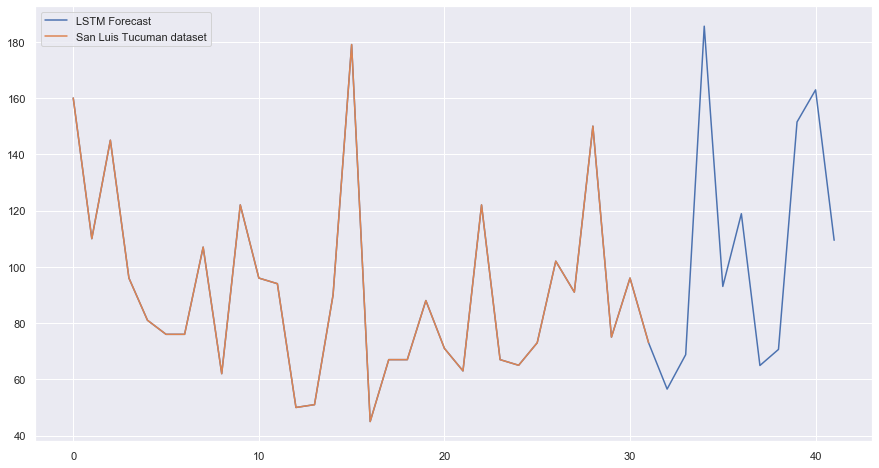

In [15]:
plt.plot(rain_forecats, label='LSTM Forecast')
plt.plot(dataset, label='San Luis Tucuman dataset' )
plt.legend();

## LSTM sobre datos del FBI (background checks)

Probamos ahora la misma idea para los datos de *background checks* del FBI.

In [16]:
df = pd.read_csv('../clase_4/data/firearms.csv', parse_dates=['month'])

In [17]:
df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2020-04-01,Alabama,21276.0,386.0,28951.0,12512.0,1455.0,1272,0.0,27.0,...,0.0,0.0,0.0,31.0,30.0,7.0,0.0,0.0,0.0,70748
1,2020-04-01,Alaska,85.0,68.0,3942.0,3275.0,510.0,245,0.0,1.0,...,0.0,0.0,0.0,11.0,9.0,3.0,0.0,0.0,0.0,8560
2,2020-04-01,Arizona,4500.0,675.0,33391.0,13143.0,2369.0,3121,0.0,26.0,...,0.0,0.0,0.0,25.0,19.0,3.0,0.0,0.0,0.0,59986
3,2020-04-01,Arkansas,3085.0,801.0,13814.0,8463.0,612.0,678,1.0,28.0,...,0.0,1.0,0.0,26.0,15.0,1.0,0.0,1.0,0.0,30575
4,2020-04-01,California,24460.0,0.0,59219.0,31759.0,6330.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122999


In [18]:
total = df[['totals', 'month']].groupby('month').sum();

In [19]:
total.head()

,totals
month,
1998-11-01,21176
1998-12-01,870722
1999-01-01,585974
1999-02-01,690215
1999-03-01,741687


In [20]:
total = total.drop(total.iloc[[0]].index)

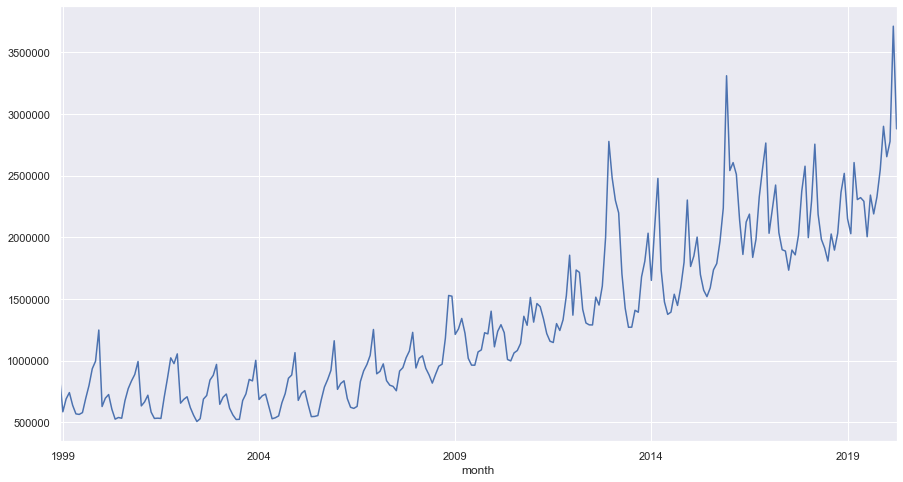

In [21]:
total['totals'].plot();

In [22]:
dataset = total['totals'].values[:-24]

In [23]:
n_features = 1
n_steps = 12
X, y = split_sequence(dataset, n_steps)

In [24]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [25]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

In [26]:
x_ = np.array(dataset[-n_steps:])
y = []
for j in range(24):   
    x_input = x_.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_ = np.append(x_[1:],yhat)
    y.append(yhat)

In [27]:
prediction = np.zeros(24)
for i in range(len(prediction)):
    prediction[i] = y[i][0][0]

In [28]:
forecast = total['totals'].copy()[-24:]
forecast[:] = prediction

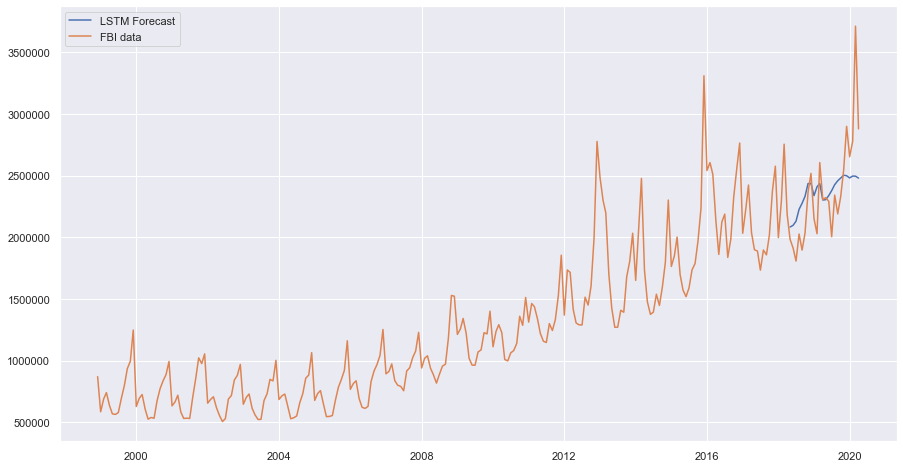

In [29]:
plt.plot(forecast, label='LSTM Forecast')
plt.plot(total['totals'], label='FBI data' )
plt.legend();

## Wavelets decomposition -> LSTM

https://github.com/samluxenberg1/Time-Series-Forecasting-with-Wavelets/blob/master/Time%20Series%20Forecasts%20Via%20Wavelets_An%20Application%20to%20Car%20Sales%20in%20the%20Spanish%20Market.pdf

Ahora probamos la misma red pero haciendo una descomposición *Wavelet* primero, usando una red para cada componente y después sumando.

In [30]:
import pywt

In [31]:
(cA, cD) = pywt.dwt(dataset,'db2')

In [32]:
detail = pywt.idwt(None,cD, 'db2')
approx = pywt.idwt(cA, None, 'db2')

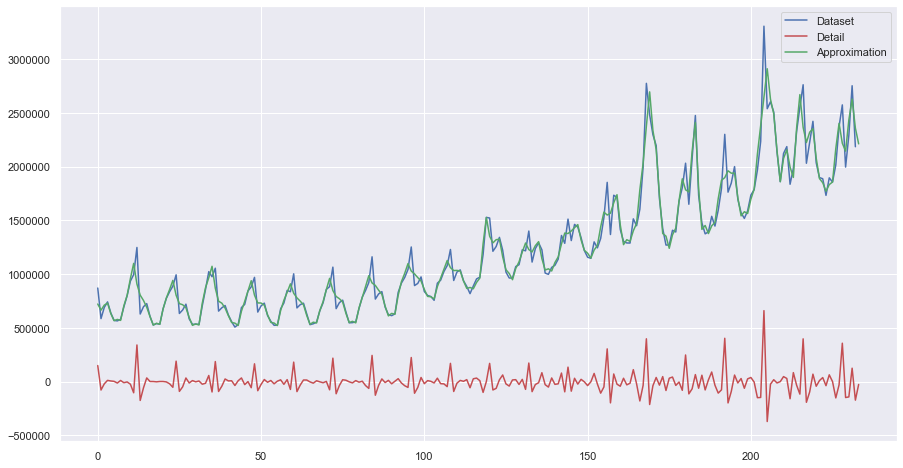

In [33]:
plt.plot(dataset,'-b', label='Dataset' )
plt.plot(detail, '-r', label='Detail')
plt.plot(approx,'-g', label='Approximation')
plt.legend();

In [34]:
n_features = 1
n_steps = 12
X, y = split_sequence(detail, n_steps)

In [35]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [36]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

In [37]:
x_ = np.array(detail[-n_steps:])
y = []
for j in range(24):   
    x_input = x_.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_ = np.append(x_[1:],yhat)
    y.append(yhat)

In [38]:
prediction_detail = np.zeros(24)
for i in range(len(prediction_detail)):
    prediction_detail[i] = y[i][0][0]

In [39]:
forecast_detail = total['totals'].copy()[-24:]
forecast_detail[:] = prediction_detail

In [40]:
X, y = split_sequence(approx, n_steps)

In [41]:
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [42]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=200, verbose=0)

In [43]:
x_ = np.array(approx[-n_steps:])
y = []
for j in range(24):   
    x_input = x_.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_ = np.append(x_[1:],yhat)
    y.append(yhat)

In [44]:
prediction_approx = np.zeros(24)
for i in range(len(prediction_approx)):
    prediction_approx[i] = y[i][0][0]

In [45]:
forecast_approx = total['totals'].copy()[-24:]
forecast_approx[:] = prediction_approx

In [46]:
forecast_final = forecast_detail + forecast_approx

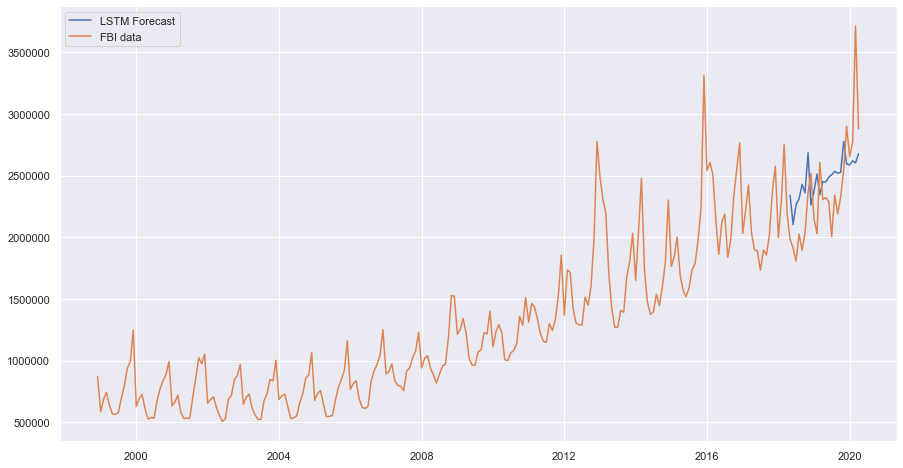

In [47]:
plt.plot(forecast_final, label='LSTM Forecast')
plt.plot(total['totals'], label='FBI data' )
plt.legend();

## Varios fits

Hasta ahora no lo dijimos, pero el entrenamiento (y por lo tanto también la predicción) de una red neuronal es estocástico. Para hacernos una idea de cuánto puede variar este entrenamiento ahora hacemos el mismo fit que antes cinco veces y ploteamos cada predicción.

In [48]:
forecasts_detail = {}
for i in range(5):
    dataset = detail 
    n_features = 1
    n_steps = 12
    X, y = split_sequence(dataset, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=0)
    x_ = np.array(dataset[-12:])
    y = []
    for j in range(24):   
        x_input = x_.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        x_ = np.append(x_[1:],yhat)
        y.append(yhat)
    forecasts_detail[i] = y

In [49]:
forecasts_approx = {}
for i in range(5):
    dataset = approx
    n_features = 1
    n_steps = 12
    X, y = split_sequence(dataset, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=200, verbose=0)
    x_ = np.array(dataset[-12:])
    y = []
    for j in range(24):   
        x_input = x_.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        x_ = np.append(x_[1:],yhat)
        y.append(yhat)
    forecasts_approx[i] = y

In [50]:
predictions_detail = np.zeros((5, 24))
for i in range(5):
    predictions_detail[i] = np.array(forecasts_detail[i]).flatten()

In [51]:
forecasts_final_detail = [None] * 5
for i in range(5):
    forecasts_final_detail[i] = total['totals'].copy()[-24:]
    forecasts_final_detail[i][:] = predictions_detail[i]

In [52]:
predictions_approx = np.zeros((5, 24))
for i in range(5):
    predictions_approx[i] = np.array(forecasts_approx[i]).flatten()

In [53]:
forecasts_final_approx = [None] * 5
for i in range(5):
    forecasts_final_approx[i] = total['totals'].copy()[-24:]
    forecasts_final_approx[i][:] = predictions_approx[i]

In [54]:
forecasts_final = []
for i in range(5):
    forecasts_final.append(forecasts_final_detail[i] + forecasts_final_approx[i])

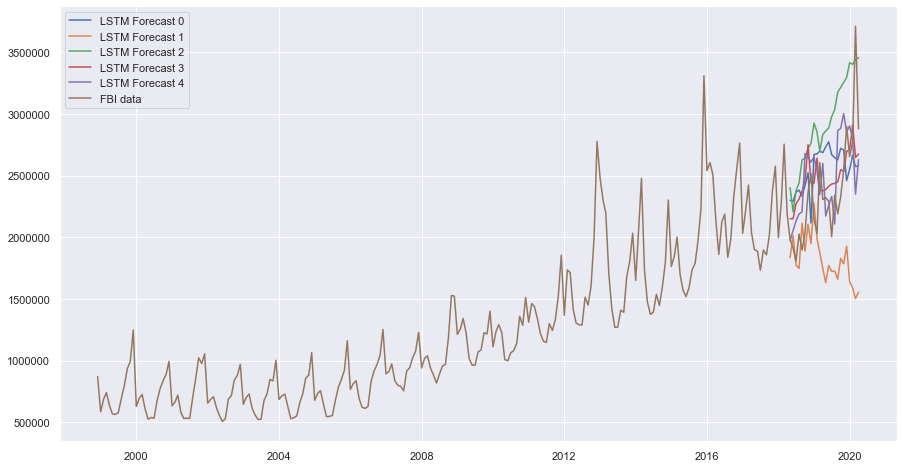

In [55]:
for i in range(5):
    plt.plot(forecasts_final[i], label='LSTM Forecast {}'.format(i))
plt.plot(total['totals'], label='FBI data' )
plt.legend();

Claramente la componente estocástica no es menor; por supuesto esto depende de cada caso particular, en general cuantos más datos y más entrenamiento más chico es el efecto de esta componente. En este caso parece ser bastante grande, así que para hacer una última predicción hacemos un promedio de las cinco anteriores.

### Promedio

In [56]:
final_prediction_mean_detail = np.array([])
for i in range(24):
    mean = []
    for j in range(5):
        mean.append(predictions_detail[j][i])
    final_prediction_mean_detail = np.append(final_prediction_mean_detail, np.mean(mean))

In [57]:
final_prediction_mean_approx = np.array([])
for i in range(24):
    mean = []
    for j in range(5):
        mean.append(predictions_approx[j][i])
    final_prediction_mean_approx = np.append(final_prediction_mean_approx, np.mean(mean))

In [58]:
final_prediction_mean = final_prediction_mean_detail + final_prediction_mean_approx

In [59]:
final_forecast_mean = total['totals'].copy()[-24:]
final_forecast_mean[:] = final_prediction_mean

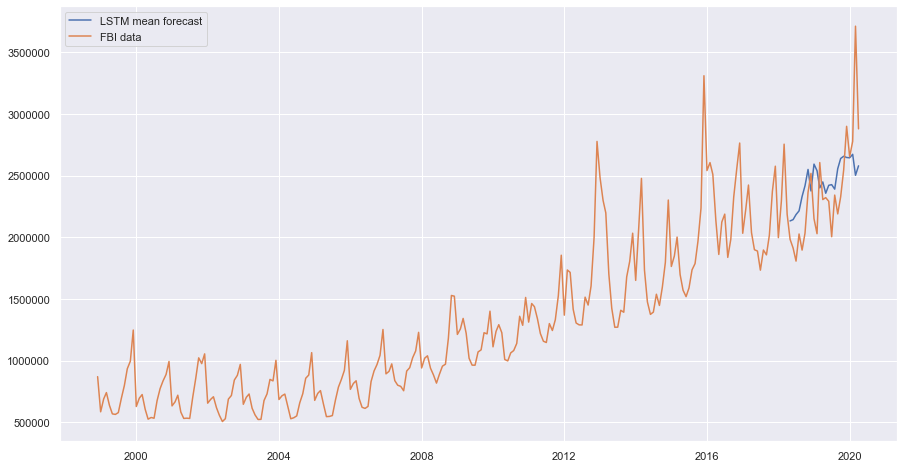

In [60]:
plt.plot(final_forecast_mean, label='LSTM mean forecast')
plt.plot(total['totals'], label='FBI data' )
plt.legend();